In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%autoreload 2

In [4]:
import elevation.prediction_pipeline
import matplotlib.pyplot as plt
import numpy as np
import azimuth.util as util
import scipy as sp
import scipy.stats as st
import sklearn
import sklearn.cross_validation
from elevation.prediction_pipeline import *

/home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/pandas/computation/__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)


In [86]:
def get_offtarget_data(feature_order=2):
    learn_options = {'num_proc': 10,
                     'nuc_features_WT': False, 'include_pi_nuc_feat': True,
                     'mutation_type' : False,
                     'mutation_details' : False,
                     'gc_features': False,
                     'annotation_onehot' : True, #featurize like CFD
                     'annotation_decoupled_onehot' : False, #decouple the CFD features into letters and position
                     "include_Tm": False,
                     'include_azimuth_score': None, # all of them ["WT","MUT","DELTA"
                     "include_gene_position": False,
                     "cv": "stratified",
                     'adaboost_loss' : 'ls',
                     'adaboost_CV': False, "algorithm_hyperparam_search" : "grid",
                     'n_folds' : 10,
                     'allowed_category' : None,#"Mismatch",#"Insertion",
                     "include_NGGX_interaction": False,
                     'normalize_features' : False, 'class_weight': None,
                     "training_metric": 'spearmanr',
                     "skip_pam_feat" : True, "letpos_indep_ft": False, "letpos_inter_ft": True,
                     "fit_intercept" : True,
                     "seed" : 12345,
                     "num_proc": 1,
                     "alpha": np.array([1.0e-3]),
                     'V': 'CD33',
                     'left_right_guide_ind': [4, 27, 30],
                     'cv': 'gene',
                     'testing_non_binary_target_name': 'ranks',
                     'azimuth_feat' : ["WT"],# , "WT"],
                     }


    learn_options['phen_transform'] = 'identity'
    Y, feature_sets, _, _, _ = elevation.model_comparison.setup_elevation(test=False, order=feature_order, learn_options=learn_options)

    keys_remove = ['Amino Acid Cut position_WT', 'Percent Peptide_WT', 'Percent Peptide <50%_WT']
    for k in keys_remove:
        if k in feature_sets.keys():
            feature_sets.pop(k)

    return Y, feature_sets, learn_options

def get_ontarget_data(feature_sets, learn_options, feature_order=2):
    learn_options["V"] = 2
    learn_options['include_strand'] = False
    learn_options['left_right_guide_ind'] = [4, 27, 30]
    learn_options['include_gene_effect'] = False
    learn_options['include_sgRNAscore'] = False
    learn_options['include_drug'] = False
    learn_options['include_gene_feature'] = False
    learn_options['extra pairs'] = False
    Y_on, feature_sets_on, _, _, _ = azimuth.model_comparison.setup(test=False, order=feature_order, 
                                                                    learn_options=learn_options, data_file=None, 
                                                                    pam_audit=True, length_audit=True)

    # rename keys
    for k in feature_sets_on.keys():
        if k == 'Percent Peptide <50%' or k=='Amino Acid Cut position':
            feature_sets_on.pop(k)
            continue
        if k != 'Percent Peptide':
            feature_sets_on[k+'_WT'] = feature_sets_on.pop(k)


    # add empty MUT entries
    for k in feature_sets:
        if k not in feature_sets_on.keys():
            # if "nuc" in k:
            #     d =
            d = np.zeros((feature_sets_on[feature_sets_on.keys()[0]].shape[0], feature_sets[k].shape[1]))
            # d = np.ones((feature_sets_on[feature_sets_on.keys()[0]].shape[0], feature_sets[k].shape[1])) * -9
            feature_sets_on[k] = pandas.DataFrame(d, columns= feature_sets[k].columns, index=feature_sets_on[feature_sets_on.keys()[0]].index)

    return Y_on, feature_sets_on


def merge_data(feature_order=2, transform=None):
    Y_off, feature_sets_off, learn_options = get_offtarget_data(feature_order=feature_order)
    Y_on, feature_sets_on = get_ontarget_data(feature_sets_off, learn_options, feature_order=feature_order)

    to_remove = []# ['_nuc_pd_Order1_WT']#, 'annot_decoupled']#, 'Percent Peptide']
    for k in to_remove:
        feature_sets_on.pop(k)
        feature_sets_off.pop(k)


    ordered_keys = feature_sets_on.keys()


    # if '_nuc_pd_Order1_WT' in ordered_keys:
    #     feature_sets_on['_nuc_pd_Order1_WT'] = (feature_sets_on['_nuc_pd_Order1_WT']/feature_sets_on['_nuc_pd_Order1_WT'].sum(0)).fillna(0)
    #     feature_sets_off['_nuc_pd_Order1_WT'] = (feature_sets_off['_nuc_pd_Order1_WT']/feature_sets_off['_nuc_pd_Order1_WT'].sum(0)).fillna(0)

    print ordered_keys
    inputs_on = azimuth.util.concatenate_feature_sets(feature_sets_on, keys=ordered_keys)[0]
    inputs_off = azimuth.util.concatenate_feature_sets(feature_sets_off, keys=ordered_keys)[0]


    target_off = Y_off['Day21-ETP'].values

    if transform is None:
        target_on = Y_on['score'].values

    if transform == 'rank':
        target_off = azimuth.util.get_ranks(pandas.DataFrame(Y_off['Day21-ETP']))[0].values.flatten()
        target_on = Y_on['score_drug_gene_rank'].values
    elif transform == 'binary':
        target_off = target_off > 1.0
        target_on = Y_on['score_drug_gene_threshold'].values


    # sel = target_on<0.0
    # target_on = target_on[sel]
    # inputs_on = inputs_on[sel]
    # import ipdb; ipdb.set_trace()

    target = np.concatenate((target_on, target_off))
    inputs = np.concatenate((inputs_on, inputs_off))

    num_on, num_off = inputs_on.shape[0], inputs_off.shape[0]

    dataset_enc = np.zeros((inputs.shape[0], 1))
    dataset_enc[:num_on] = 1.
    inputs = np.concatenate((inputs, dataset_enc), axis=1)


    return target, inputs, num_on, num_off, Y_on

In [109]:
Y_off, feature_sets_off, learn_options = get_offtarget_data(feature_order=1)
Y_on, feature_sets_on = get_ontarget_data(feature_sets_off, learn_options, feature_order=1)
Y_on = Y_on['score'].values[:, None]
Y_off = Y_off['Day21-ETP'].values[:, None]

MKL not available, so I'm not adjusting the number of threads
Launching 1 jobs with 1 MKL threads each
loading processed data from file: ../../data/offtarget/CD33.processed.[4, 27, 30].pamfiltTrue.p...
done.
featurizing data...
done.
MKL not available, so I'm not adjusting the number of threads
Launching 1 jobs with 1 MKL threads each
Loaded 64 samples for gene HPRT1 	total number of samples: 64
Loaded 149 samples for gene CCDC101 	total number of samples: 213
Loaded 924 samples for gene MED12 	total number of samples: 1137
Loaded 190 samples for gene TADA2B 	total number of samples: 1327
Loaded 109 samples for gene TADA1 	total number of samples: 1436
Loaded 154 samples for gene CUL3 	total number of samples: 1590
Loaded 736 samples for gene NF1 	total number of samples: 2326
Loaded 223 samples for gene NF2 	total number of samples: 2549
Loaded 924 samples for gene MED12 	total number of samples: 3473
Constructing features...
		constructing order 1 features
							done
		Elapsed time 

In [195]:
num_test = 500
perm = np.random.permutation(Y_on.shape[0])
test_on = perm[:num_test]
train_on = perm[num_test:]

perm = np.random.permutation(Y_off.shape[0])
test_off = perm[:num_test]
train_off = perm[num_test:]

ordered_keys = feature_sets_on.keys()
X_on = azimuth.util.concatenate_feature_sets(feature_sets_on, keys=ordered_keys)[0]
X_off = azimuth.util.concatenate_feature_sets(feature_sets_off, keys=ordered_keys)[0]
X_all = np.concatenate((X_off, X_on), axis=0)
Y_all = np.concatenate((Y_off, Y_on), axis=0)
X_train = np.concatenate((X_off[train_off], X_on[train_on]), axis=0)
X_test = np.concatenate((X_off[test_off], X_on[test_on]), axis=0)
Y_test = np.concatenate((Y_off[test_off], Y_on[test_on]), axis=0)
Y_train = np.concatenate((Y_off[train_off], Y_on[train_on]), axis=0)

In [196]:
clf_merged = sklearn.ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
clf_merged.fit(X_train, Y_train)
# pred_merged = clf_merged.predict(X_off[test_off])

clf_off = sklearn.ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
clf_off.fit(X_off[train_off], Y_off[train_off])
# pred_off = clf_off.predict(X_off[test_off])

clf_on = sklearn.ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
clf_on.fit(X_on[train_on], Y_on[train_on])

clf_on_only = sklearn.ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
clf_on_only.fit(X_on, Y_on)
# clf_on.predict(X_off[test_off])

clf_off_only = sklearn.ensemble.GradientBoostingRegressor(n_estimators=100, max_depth=3, learning_rate=0.1)
clf_off_only.fit(X_off, Y_off)

 /home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 /home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 /home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
 /home/nicolo/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn/utils/validation.py:515: DataConversionWarning:A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usi

GradientBoostingRegressor(alpha=0.9, init=None, learning_rate=0.1, loss='ls',
             max_depth=3, max_features=None, max_leaf_nodes=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

In [197]:
print sp.stats.spearmanr(clf_merged.predict(X_off[test_off]), Y_off[test_off])
print sp.stats.spearmanr(clf_off.predict(X_off[test_off]), Y_off[test_off])
print sp.stats.spearmanr(clf_on_only.predict(X_off[test_off]), Y_off[test_off])

SpearmanrResult(correlation=0.63850768671278013, pvalue=1.2913034012853255e-58)
SpearmanrResult(correlation=0.65509062830902176, pvalue=1.2906989898449198e-62)
SpearmanrResult(correlation=0.33913188978518843, pvalue=6.3663784605629282e-15)


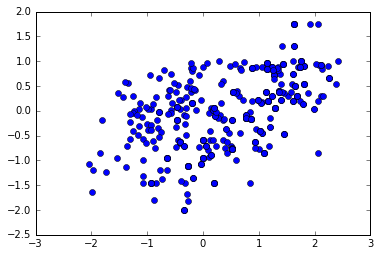

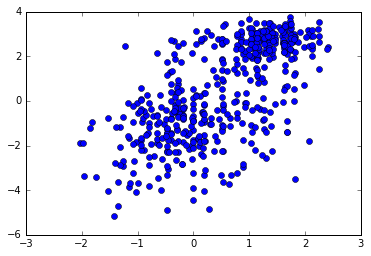

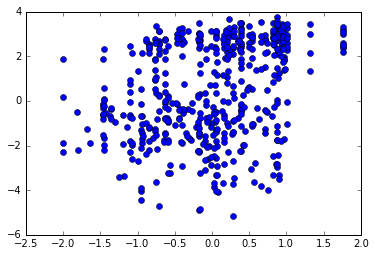

In [198]:
plt.figure()
plt.plot(clf_off.predict(X_off[test_off]), clf_on_only.predict(X_off[test_off]), 'o')
plt.figure()
plt.plot(clf_off.predict(X_off[test_off]), Y_off[test_off], 'o')
plt.figure()
plt.plot(clf_on_only.predict(X_off[test_off]), Y_off[test_off], 'o')

In [199]:
print sp.stats.spearmanr(clf_merged.predict(X_on[test_on]), Y_on[test_on])
print sp.stats.spearmanr(clf_on.predict(X_on[test_on]), Y_on[test_on])
print sp.stats.spearmanr(clf_off_only.predict(X_on[test_on]), Y_on[test_on])

SpearmanrResult(correlation=0.36562327566742958, pvalue=2.9273524685633197e-17)
SpearmanrResult(correlation=0.48010310829454134, pvalue=3.4277451191894654e-30)
SpearmanrResult(correlation=0.24273285179202184, pvalue=3.8740325590759062e-08)


In [200]:
guideseq_data = load_guideseq(learn_options)

In [201]:
predictions_by_pos = dict([(k, np.ones((guideseq_data.shape[0], 23))) for k in ['merged', 'off', 'on']])
for i in range(guideseq_data.shape[0]):
    print i, guideseq_data.shape[0]
    row_data = guideseq_data.iloc[i]
    for a in row_data["Annotation"]:
        row_data_a = row_data.copy()
        row_data_a['Annotation'] = [a]
        X_gs_i_a = featurize_data_elevation(pandas.DataFrame([row_data_a]), learn_options)[0]
        if ':' in a:
            pos = int(a.split(",")[1])
        else:
            pos = 22
            
        X_gs_i_a = azimuth.util.concatenate_feature_sets(X_gs_i_a, keys=ordered_keys)[0]
        
        predictions_by_pos['on'][i, pos] = clf_on_only.predict(X_gs_i_a)
        predictions_by_pos['off'][i, pos] = clf_off_only.predict(X_gs_i_a)
        predictions_by_pos['merged'][i, pos] = clf_merged.predict(X_gs_i_a)

0 402
1 402
2 402
3 402
4 402
5 402
6 402
7 402
8 402
9 402
10 402
11 402
12 402
13 402
14 402
15 402
16 402
17 402
18 402
19 402
20 402
21 402
22 402
23 402
24 402
25 402
26 402
27 402
28 402
29 402
30 402
31 402
32 402
33 402
34 402
35 402
36 402
37 402
38 402
39 402
40 402
41 402
42 402
43 402
44 402
45 402
46 402
47 402
48 402
49 402
50 402
51 402
52 402
53 402
54 402
55 402
56 402
57 402
58 402
59 402
60 402
61 402
62 402
63 402
64 402
65 402
66 402
67 402
68 402
69 402
70 402
71 402
72 402
73 402
74 402
75 402
76 402
77 402
78 402
79 402
80 402
81 402
82 402
83 402
84 402
85 402
86 402
87 402
88 402
89 402
90 402
91 402
92 402
93 402
94 402
95 402
96 402
97 402
98 402
99 402
100 402
101 402
102 402
103 402
104 402
105 402
106 402
107 402
108 402
109 402
110 402
111 402
112 402
113 402
114 402
115 402
116 402
117 402
118 402
119 402
120 402
121 402
122 402
123 402
124 402
125 402
126 402
127 402
128 402
129 402
130 402
131 402
132 402
133 402
134 402
135 402
136 402
137 402
138 40

In [202]:
merged_pred = predictions_by_pos['merged']
off_pred = predictions_by_pos['off']
on_pred = predictions_by_pos['on']

In [203]:
predictions, performance, mismatches, truth, c_pred =  elevation.prediction_pipeline.cross_validate_guideseq(guideseq_data, 
                                                                                                     merged_pred, 
                                                                                                     learn_options,
                                                                                models= ['GP-stacker', 'CFD', 'product',
                                                                               'linear-raw-stacker', 'logistic stacker'])

Loading CFD table from file
Fold 1, Spearman r: GP-stacker=0.172 CFD=0.072 logistic stacker=0.218 product=-0.068 linear-raw-stacker=0.120 
Loading CFD table from file
Fold 2, Spearman r: GP-stacker=0.520 CFD=0.312 logistic stacker=0.416 product=-0.007 linear-raw-stacker=0.221 
Loading CFD table from file
Fold 3, Spearman r: GP-stacker=0.487 CFD=0.720 logistic stacker=0.481 product=-0.010 linear-raw-stacker=0.455 
Loading CFD table from file
Fold 4, Spearman r: GP-stacker=0.166 CFD=0.326 logistic stacker=0.176 product=-0.229 linear-raw-stacker=0.368 
Loading CFD table from file
Fold 5, Spearman r: GP-stacker=0.072 CFD=0.353 logistic stacker=-0.166 product=-0.387 linear-raw-stacker=0.463 
Loading CFD table from file
Fold 6, Spearman r: GP-stacker=0.388 CFD=-0.174 logistic stacker=0.370 product=0.416 linear-raw-stacker=0.439 
Loading CFD table from file
Fold 7, Spearman r: GP-stacker=0.193 CFD=0.153 logistic stacker=0.252 product=0.081 linear-raw-stacker=0.607 
Loading CFD table from file

In [204]:
predictions, performance, mismatches, truth, c_pred =  elevation.prediction_pipeline.cross_validate_guideseq(guideseq_data, 
                                                                                                     off_pred, 
                                                                                                     learn_options,
                                                                                models= ['GP-stacker', 'CFD', 'product',
                                                                               'linear-raw-stacker', 'logistic stacker'])

Loading CFD table from file
Fold 1, Spearman r: GP-stacker=0.176 CFD=0.072 logistic stacker=0.089 product=0.278 linear-raw-stacker=0.085 
Loading CFD table from file
Fold 2, Spearman r: GP-stacker=0.451 CFD=0.312 logistic stacker=0.344 product=-0.053 linear-raw-stacker=0.208 
Loading CFD table from file
Fold 3, Spearman r: GP-stacker=0.368 CFD=0.720 logistic stacker=0.499 product=0.048 linear-raw-stacker=0.422 
Loading CFD table from file
Fold 4, Spearman r: GP-stacker=0.313 CFD=0.326 logistic stacker=0.274 product=-0.049 linear-raw-stacker=0.375 
Loading CFD table from file
Fold 5, Spearman r: GP-stacker=-0.080 CFD=0.353 logistic stacker=-0.321 product=-0.074 linear-raw-stacker=0.450 
Loading CFD table from file
Fold 6, Spearman r: GP-stacker=0.233 CFD=-0.174 logistic stacker=0.247 product=0.035 linear-raw-stacker=0.362 
Loading CFD table from file
Fold 7, Spearman r: GP-stacker=0.072 CFD=0.153 logistic stacker=0.248 product=0.206 linear-raw-stacker=0.584 
Loading CFD table from file


In [194]:
predictions, performance, mismatches, truth, c_pred =  elevation.prediction_pipeline.cross_validate_guideseq(guideseq_data, 
                                                                                                     on_pred, 
                                                                                                     learn_options,
                                                                                models= ['GP-stacker', 'CFD', 'product',
                                                                               'linear-raw-stacker', 'logistic stacker'])

Loading CFD table from file
Fold 1, Spearman r: GP-stacker=0.239 CFD=0.072 logistic stacker=0.026 product=-0.070 linear-raw-stacker=0.167 
Loading CFD table from file
Fold 2, Spearman r: GP-stacker=0.397 CFD=0.312 logistic stacker=0.299 product=0.283 linear-raw-stacker=0.301 
Loading CFD table from file
Fold 3, Spearman r: GP-stacker=0.442 CFD=0.720 logistic stacker=0.095 product=0.338 linear-raw-stacker=0.558 
Loading CFD table from file
Fold 4, Spearman r: GP-stacker=0.270 CFD=0.326 logistic stacker=-0.064 product=-0.409 linear-raw-stacker=0.322 
Loading CFD table from file
Fold 5, Spearman r: GP-stacker=0.236 CFD=0.353 logistic stacker=-0.049 product=-0.075 linear-raw-stacker=0.383 
Loading CFD table from file
Fold 6, Spearman r: GP-stacker=0.336 CFD=-0.174 logistic stacker=0.399 product=-0.090 linear-raw-stacker=0.427 
Loading CFD table from file
Fold 7, Spearman r: GP-stacker=0.345 CFD=0.153 logistic stacker=0.044 product=0.080 linear-raw-stacker=0.584 
Loading CFD table from file